
# Electricity Price Forecasting with N-BEATS

* **Author:** Ethan Harris (ethan@pytorchlightning.ai)
* **License:** CC BY-SA
* **Generated:** 2021-11-30T16:13:40.850099

This tutorial covers using Lightning Flash and it's integration with PyTorch Forecasting to train an autoregressive
model (N-BEATS) on hourly electricity pricing data. We show how the built-in interpretability tools from PyTorch
Forecasting can be used with Flash to plot the trend and daily seasonality in our data discovered by the model. We
also cover how features from PyTorch Lightning such as the learning rate finder can be used easily with Flash. As a
bonus, we show hat we can resample daily observations from the data to discover weekly trends instead.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/flash_tutorials/electricity_forecasting.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/latest/)
| Join us [on Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-pw5v393p-qRaDgEk24~EjiZNBpSQFgQ)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "torchmetrics>=0.3" "lightning-flash[tabular]>=0.5.2" "pandas==1.1.5" "torch>=1.6, <1.9" "pytorch-lightning>=1.3"

In this tutorial we'll look at using [Lightning Flash](https://github.com/PyTorchLightning/lightning-flash) and it's
integration with [PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting) for autoregressive modelling of
electricity prices using [the N-BEATS model](https://arxiv.org/abs/1905.10437).
We'll start by using N-BEATS to uncover daily patterns (seasonality) from hourly observations and then show how we can
resample daily averages to uncover weekly patterns too.

Along the way, we'll see how the built-in tools from PyTorch Lightning, like the learning rate finder, can be used
seamlessly with Flash to help make the process of putting a model together as smooth as possible.

In [2]:

import os

import flash
import matplotlib.pyplot as plt
import pandas as pd
import torch
from flash.core.data.utils import download_data
from flash.core.integrations.pytorch_forecasting import convert_predictions
from flash.tabular.forecasting import TabularForecaster, TabularForecastingData

DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")

## Loading the data

We'll use the Spanish hourly energy demand generation and weather data set from Kaggle:
https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather

First, download the data:

In [3]:
download_data("https://pl-flash-data.s3.amazonaws.com/kaggle_electricity.zip", DATASET_PATH)

/usr/local/lib/python3.9/dist-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pl-flash-data.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


/__w/1/s/.datasets/kaggle_electricity.zip:   0%|          | 0/3903 [00:00<?, ?KB/s]

## Data loading

To load the data, we start by loading the CSV file into a pandas DataFrame:

In [4]:
df_energy_hourly = pd.read_csv(f"{DATASET_PATH}/energy_dataset.csv", parse_dates=["time"])

Before we can load the data into Flash, there are a few preprocessing steps we need to take.
The first preprocessing step is to set the `time` field as the index (formatted as a datetime).
The second step is to resample the data to the desired frequency in case it is different from the desired observation
frequency.
Since we are performing autoregressive modelling, we can remove all columns except for `"price actual"`.

For the third preprocessing step, we need to create a "time_idx" column.
The "time_idx" column should contain integers corresponding to the observation index (e.g. in our case the difference
between two "time_idx" values is the number of hours between the observations).
To do this we convert the datetime to an index by taking the nanoseconds value and dividing by the number of
nanoseconds in a single unit of our chosen frequency.
We then subtract the minimum value so it starts at zero (although it would still work without this step).

The Flash `TabularForecastingData` (which uses the `TimeSeriesDataSet` from PyTorch Forecasting internally) also
supports loading data from multiple time series (e.g. you may have electricity data from multiple countries).
To indicate that our data is all from the same series, we add a `constant` column with a constant value of zero.

Here's the full preprocessing function:

In [5]:


def preprocess(df: pd.DataFrame, frequency: str = "1H") -> pd.DataFrame:
    df["time"] = pd.to_datetime(df["time"], utc=True, infer_datetime_format=True)
    df.set_index("time", inplace=True)

    df = df.resample(frequency).mean()

    df = df.filter(["price actual"])

    df["time_idx"] = (df.index.view(int) / pd.Timedelta(frequency).value).astype(int)
    df["time_idx"] -= df["time_idx"].min()

    df["constant"] = 0

    return df


df_energy_hourly = preprocess(df_energy_hourly)

## Creating the Flash DataModule

Now, we can create a `TabularForecastingData`.
The role of the `TabularForecastingData` is to split up our time series into windows which include a region to encode
(of size `max_encoder_length`) and a region to predict (of size `max_prediction_length`) which will be used to compute
the loss.
The size of the prediction window should be chosen depending on the kinds of trends we would like our model to
uncover.
In our case, we are interested in how electricity prices change throughout the day, so a one day prediction window
(`max_prediction_length = 24`) makes sense here.
The size of the encoding window can vary, however, in the [N-BEATS paper](https://arxiv.org/abs/1905.10437) the
authors suggest using an encoder length of between two and ten times the prediction length.
We therefore choose two days (`max_encoder_length = 48`) as the encoder length.

In [6]:
max_prediction_length = 24
max_encoder_length = 24 * 2

training_cutoff = df_energy_hourly["time_idx"].max() - max_prediction_length

datamodule = TabularForecastingData.from_data_frame(
    time_idx="time_idx",
    target="price actual",
    group_ids=["constant"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["price actual"],
    train_data_frame=df_energy_hourly[df_energy_hourly["time_idx"] <= training_cutoff],
    val_data_frame=df_energy_hourly,
    batch_size=256,
)

## Creating the Flash Task

Now, we're ready to create a `TabularForecaster`.
The N-BEATS model has two primary hyper-parameters:`"widths"`, and `"backcast_loss_ratio"`.
In the [PyTorch Forecasting Documentation](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.nbeats.NBeats.html),
the authors recommend using `"widths"` of `[32, 512]`.
In order to prevent overfitting with smaller datasets, a good rule of thumb is to limit the number of parameters of
your model.
For this reason, we use `"widths"` of `[16, 256]`.

To understand the `"backcast_loss_ratio"`, let's take a look at this diagram of the model taken from
[the arXiv paper](https://arxiv.org/abs/1905.10437):

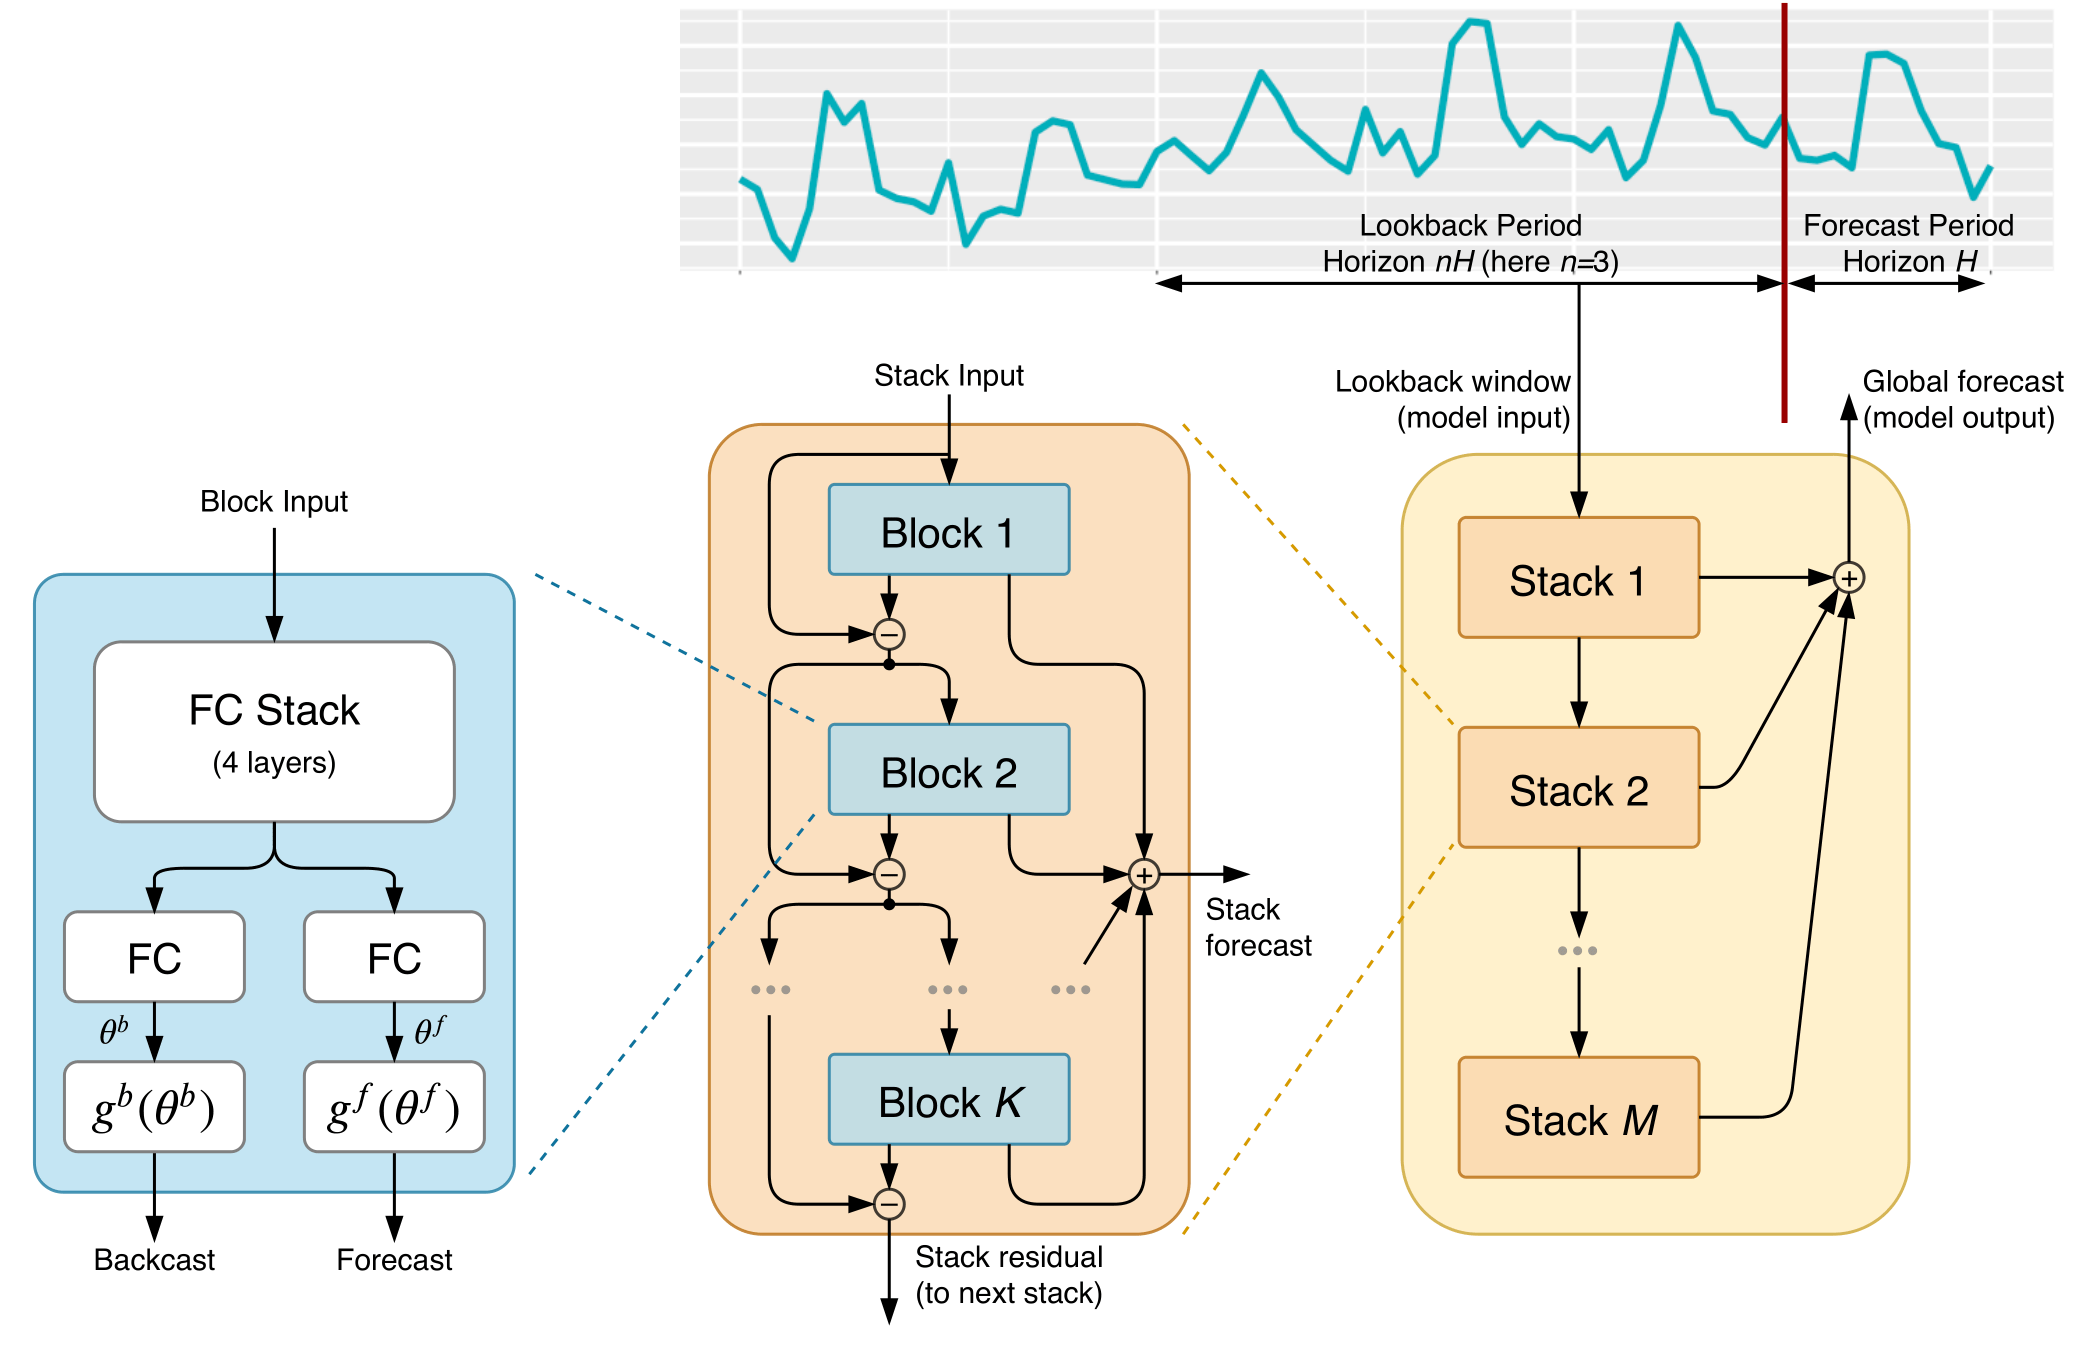

Each 'block' within the N-BEATS architecture includes a forecast output and a backcast which can each yield their own
loss.
The `"backcast_loss_ratio"` is the ratio of the backcast loss to the forecast loss.
A value of `1.0` means that the loss function is simply the sum of the forecast and backcast losses.

In [7]:
model = TabularForecaster(
    datamodule.parameters, backbone="n_beats", backbone_kwargs={"widths": [16, 256], "backcast_loss_ratio": 1.0}
)

/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Using 'n_beats' provided by jdb78/PyTorch-Forecasting (https://github.com/jdb78/pytorch-forecasting).


## Finding the learning rate

Tabular models can be particularly sensitive to the choice of learning rate.
Helpfully, PyTorch Lightning provides a built-in learning rate finder that suggests a suitable learning rate
automatically.
To use it, we first create our Trainer.
We apply gradient clipping (a common technique for tabular tasks) with ``gradient_clip_val=0.01`` in order to help
prevent our model from over-fitting.
Here's how to find the learning rate:

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:90: LightningDeprecationWarning: Method `on_train_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `train_dataloader()` directly.
  rank_zero_deprecation(
/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:125: LightningDeprecationWarning: Method `on_val_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `val_dataloader()` directly.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


LR finder stopped early after 84 steps due to diverging loss.


Restoring states from the checkpoint path at /__w/1/s/lr_find_temp_model_bb5b5629-1a66-4b55-ab12-169655e70558.ckpt


Suggested learning rate: 0.0006309573444801932


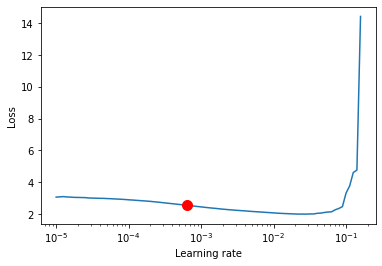

In [8]:
trainer = flash.Trainer(
    max_epochs=3,
    gpus=int(torch.cuda.is_available()),
    gradient_clip_val=0.01,
)

res = trainer.tuner.lr_find(model, datamodule=datamodule, min_lr=1e-5)
print(f"Suggested learning rate: {res.suggestion()}")
res.plot(show=True, suggest=True).show()

Once the suggest learning rate has been found, we can update our model with it:

In [9]:
model.learning_rate = res.suggestion()

## Training the model
Now all we have to do is train the model!

In [10]:
trainer.fit(model, datamodule=datamodule)

/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | ModuleDict                | 0     
1 | val_metrics   | ModuleDict                | 0     
2 | test_metrics  | ModuleDict                | 0     
3 | adapter       | PyTorchForecastingAdapter | 454 K 
------------------------------------------------------------
454 K     Trainable params
0         Non-trainable params
454 K     Total params
1.820     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


## Plot the interpretation

An important feature of the N-BEATS model is that it can be configured to produce an interpretable prediction that is
split into both a low frequency (trend) component and a high frequency (seasonality) component.
For hourly observations, we might expect the trend component to show us how electricity prices are changing from one
day to the next (for example, whether prices were generally higher or lower than yesterday).
In contrast, the seasonality component would be expected to show us the general pattern in prices through the day
(for example, if there is typically a peak in price around lunch time or a drop at night).

It is often useful to visualize this decomposition and the `TabularForecaster` makes it simple.
First, we load the best model from our training run and generate some predictions.
Next, we convert the predictions to the format expected by PyTorch Forecasting using the `convert_predictions` utility
function.
Finally, we plot the interpretation using the `pytorch_forecasting_model` attribute.
Here's the full function:

In [11]:


def plot_interpretation(model_path: str, predict_df: pd.DataFrame):
    model = TabularForecaster.load_from_checkpoint(model_path)
    predictions = model.predict(predict_df)
    predictions, inputs = convert_predictions(predictions)
    model.pytorch_forecasting_model.plot_interpretation(inputs, predictions, idx=0)
    plt.show()

And now we run the function to plot the trend and seasonality curves:

/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Using 'n_beats' provided by jdb78/PyTorch-Forecasting (https://github.com/jdb78/pytorch-forecasting).


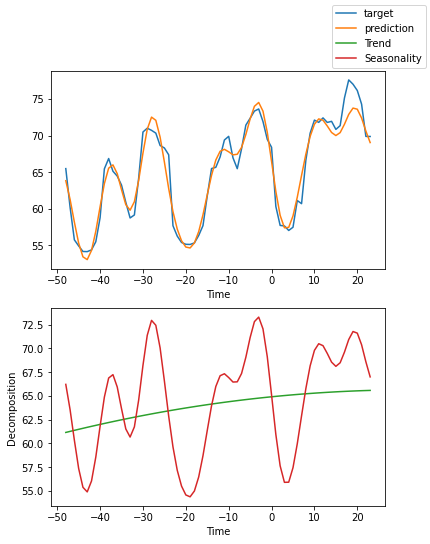

In [12]:
plot_interpretation(trainer.checkpoint_callback.best_model_path, df_energy_hourly)

It worked! The plot shows that the `TabularForecaster` does a reasonable job of modelling the time series and also
breaks it down into a trend component and a seasonality component (in this case showing daily fluctuations in
electricity prices).

## Bonus: Weekly trends

The type of seasonality that the model learns to detect is dictated by the frequency of observations and the length of
the encoding / prediction window.
We might imagine that our pipeline could be changed to instead uncover weekly trends if we resample daily
observations from our data instead of hourly.

We can use our preprocessing function to do this.
First, we load the data as before then preprocess it (this time setting `frequency = "1D"`).

In [13]:
df_energy_daily = pd.read_csv(f"{DATASET_PATH}/energy_dataset.csv", parse_dates=["time"])
df_energy_daily = preprocess(df_energy_daily, frequency="1D")

Now let's create our `TabularForecastingData` as before, this time with a four week encoding window and a one week
prediction window.

In [14]:
max_prediction_length = 1 * 7
max_encoder_length = 4 * 7

training_cutoff = df_energy_daily["time_idx"].max() - max_prediction_length

datamodule = TabularForecastingData.from_data_frame(
    time_idx="time_idx",
    target="price actual",
    group_ids=["constant"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["price actual"],
    train_data_frame=df_energy_daily[df_energy_daily["time_idx"] <= training_cutoff],
    val_data_frame=df_energy_daily,
    batch_size=256,
)

Now it's time to create a new model and trainer.
We run for 24 times the number of epochs this time as we now have around 1/24th of the number of observations.
This time, instead of using the learning rate finder we just set the learning rate manually:

In [15]:
model = TabularForecaster(
    datamodule.parameters,
    backbone="n_beats",
    backbone_kwargs={"widths": [16, 256], "backcast_loss_ratio": 1.0},
    learning_rate=5e-4,
)

trainer = flash.Trainer(
    max_epochs=3 * 24,
    check_val_every_n_epoch=24,
    gpus=int(torch.cuda.is_available()),
    gradient_clip_val=0.01,
)

/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Using 'n_beats' provided by jdb78/PyTorch-Forecasting (https://github.com/jdb78/pytorch-forecasting).


GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


Finally, we train the new model:

In [16]:
trainer.fit(model, datamodule=datamodule)

/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:90: LightningDeprecationWarning: Method `on_train_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `train_dataloader()` directly.
  rank_zero_deprecation(
/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:125: LightningDeprecationWarning: Method `on_val_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `val_dataloader()` directly.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | ModuleDict                | 0     
1 | val_metrics   | ModuleDict                | 0     
2 | test_metrics  | ModuleDict                | 0     
3 | adapter       | PyTorchForecastingAdapter | 425 K 
------------------------------------------------------------
425 K     Trainable params
0         Non-trainable params
425 K     Total params
1.702     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_s

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Now let's look at what it learned:

/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Using 'n_beats' provided by jdb78/PyTorch-Forecasting (https://github.com/jdb78/pytorch-forecasting).


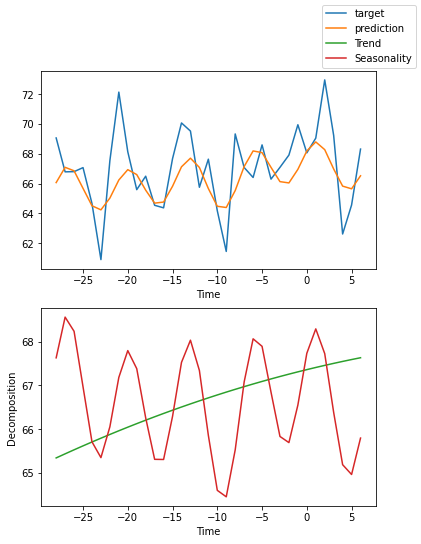

In [17]:
plot_interpretation(trainer.checkpoint_callback.best_model_path, df_energy_daily)

Success! We can now also see weekly trends / seasonality uncovered by our new model.

## Closing thoughts and next steps!

This tutorial has shown how Flash and PyTorch Forecasting can be used to train state-of-the-art auto-regressive
forecasting models (such as N-BEATS).
We've seen how we can influence the kinds of trends and patterns uncovered by the model by resampling the data and
changing the hyper-parameters.

There are plenty of ways you could take this tutorial further.
For example, you could try a more complex model, such as the
[temporal fusion transformer](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html),
which can handle additional inputs (the kaggle data set we used also includes weather data).

Alternatively, if you want to be a bit more adventurous, you could look at
[some of the other problems that can solved with Lightning Flash](https://lightning-flash.readthedocs.io/en/stable/?badge=stable).

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-pw5v393p-qRaDgEk24~EjiZNBpSQFgQ)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

Pytorch Lightning{height="60px" width="240px"}